En este archivo se llevará a cabo el entrenamiento de las coordenadas X Y en conjunto.\
Observaremos si obtenemos mejoras en función a la relación que pueda llegar a obtener la Red al entrenar ambas coordenadas.

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')
from Utils import utils_nn as utlnn

In [ ]:
x_test	= pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train	= pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test	= pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train	= pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

In [ ]:
# Definimos el radio R0
R0						= 6.371E6 # [m]
columns_drop	= [f'z_{i}' for i in range(1,101)]

y_train_xy	= y_train.drop(columns=columns_drop)/R0
y_test_xy		= y_test.drop(columns=columns_drop)/R0

In [4]:
print(y_train_xy.head())

        x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
0 -0.661554 -0.661270 -0.661261 -0.660994 -0.659421 -0.657216 -0.654940   
1 -0.661554 -0.661469 -0.661382 -0.661294 -0.661203 -0.661116 -0.661030   
2 -0.661554 -0.661293 -0.661261 -0.661065 -0.659991 -0.658167 -0.656079   
3 -0.661554 -0.661580 -0.661604 -0.661628 -0.661650 -0.661671 -0.661694   
4 -0.661554 -0.661261 -0.661237 -0.660755 -0.658829 -0.656387 -0.653944   

        x_8       x_9      x_10  ...      y_91      y_92      y_93      y_94  \
0 -0.652663 -0.650387 -0.648110  ...  0.349420  0.345299  0.341181  0.337066   
1 -0.660942 -0.660852 -0.660763  ...  0.581842  0.581477  0.581111  0.580743   
2 -0.653991 -0.651903 -0.649815  ...  0.398402  0.395023  0.391638  0.388250   
3 -0.661719 -0.661743 -0.661766  ...  0.594257  0.594107  0.593957  0.593805   
4 -0.651502 -0.649059 -0.646617  ...  0.324168  0.319754  0.316865  0.315865   

       y_95      y_96      y_97      y_98      y_99     y_100  
0  0

In [ ]:
# Quita columnas innecesarias
x_train	= x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test	= x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [6]:
print(x_train.head())
print(y_train_xy.iloc[:,:100])


   fc [Mhz]  elevation  azimuth  mmdd  hour
0        10          5       98   725    20
1        20         28       89  1215    12
2        10          5       98   608     4
3        23         34       87  1215    12
4        10          5       98   104     4
           x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
0    -0.661554 -0.661270 -0.661261 -0.660994 -0.659421 -0.657216 -0.654940   
1    -0.661554 -0.661469 -0.661382 -0.661294 -0.661203 -0.661116 -0.661030   
2    -0.661554 -0.661293 -0.661261 -0.661065 -0.659991 -0.658167 -0.656079   
3    -0.661554 -0.661580 -0.661604 -0.661628 -0.661650 -0.661671 -0.661694   
4    -0.661554 -0.661261 -0.661237 -0.660755 -0.658829 -0.656387 -0.653944   
...        ...       ...       ...       ...       ...       ...       ...   
4099 -0.661554 -0.661412 -0.661379 -0.660861 -0.659827 -0.658689 -0.657556   
4100 -0.661554 -0.661385 -0.661261 -0.661261 -0.661172 -0.661003 -0.660169   
4101 -0.661554 -0.661340 -0.661122

In [ ]:
# Escado de datos
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train_x_scaled	= scaler_x.fit_transform(y_train_xy.iloc[:,:100])
y_test_x_scaled		= scaler_x.transform(y_test_xy.iloc[:,:100])

y_train_y_scaled	= scaler_y.fit_transform(y_train_xy.iloc[:,100:])
y_test_y_scaled		= scaler_y.transform(y_test_xy.iloc[:,100:]) 


In [ ]:
reduce_lr		= ReduceLROnPlateau(
  monitor		= 'val_loss',
  patience	= 20,
  factor		= 0.5
)

In [ ]:
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, Nadam,SGD

#def 
act_name	= 'relu'
l2_reg		= 0.0007
epochs		= 700
b_s				= 32
optimizer	= Adam(learning_rate=1e-3)

#Arquitectura de la red neuronal
inputs	= Input(shape=(5,))
encoded = Dense(32,	 activation = act_name, kernel_regularizer = l2(l2_reg))(inputs)
encoded = Dense(64,	 activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(128, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(256, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(512, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(256, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)

decoded_x = Dense(100, activation = 'linear', kernel_regularizer = l2(l2_reg), name='x')(encoded)
decoded_y = Dense(100, activation = 'linear', kernel_regularizer = l2(l2_reg), name='y')(encoded)
# Def modelo multiples salidas
model_xy = Model(inputs=inputs, outputs=[decoded_x, decoded_y])
model_xy.compile(optimizer=optimizer, loss='mae')
model_xy.summary()

history_xy = model_xy.fit(x_train, [y_train_x_scaled, y_train_y_scaled],
                          epochs 						= epochs,
                          batch_size 				= b_s,
                          validation_split	= 0.1,
                          callbacks					= [reduce_lr]
                          )

                          

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     33,024 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    131,584 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x (Dense)           │ (None, 100)       │     25,700 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y (Dense)           │ (None, 100)       │     25,700 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 357,960 (1.37 MB)

 Trainable params: 357,960 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 2.7110 - x_loss: 0.9800 - y_loss: 1.0893 - val_loss: 0.5988 - val_x_loss: 0.1164 - val_y_loss: 0.1139 - learning_rate: 0.0010
Epoch 2/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5514 - x_loss: 0.0988 - y_loss: 0.0978 - val_loss: 0.5105 - val_x_loss: 0.0961 - val_y_loss: 0.0871 - learning_rate: 0.0010
Epoch 3/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4952 - x_loss: 0.0859 - y_loss: 0.0885 - val_loss: 0.4954 - val_x_loss: 0.0962 - val_y_loss: 0.0953 - learning_rate: 0.0010
Epoch 4/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4742 - x_loss: 0.0851 - y_loss: 0.0905 - val_loss: 0.4368 - val_x_loss: 0.0728 - val_y_loss: 0.0796 - learning_rate: 0.0010
Epoch 5/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4412 - x_loss: 0.0764 - y_loss: 0.0850 - val_loss: 0.4147 - val_x_loss: 0.0739 - val_y_loss: 0.0740 - learning_rate: 0.0010
Epoch 6/700
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss:

In [37]:
loss = model_xy.evaluate(x_test,[y_test_x_scaled, y_test_y_scaled])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0507 - x_loss: 0.0115 - y_loss: 0.0125


In [92]:
idx = 20

pred_x_scaled,pred_y_scaled = model_xy.predict(np.expand_dims(x_test.iloc[idx], axis=0))
pred_x = scaler_x.inverse_transform(pred_x_scaled)
pred_y = scaler_y.inverse_transform(pred_y_scaled)
true_x = y_test_xy.iloc[idx,:100].to_numpy()
true_y = y_test_xy.iloc[idx,100:].to_numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


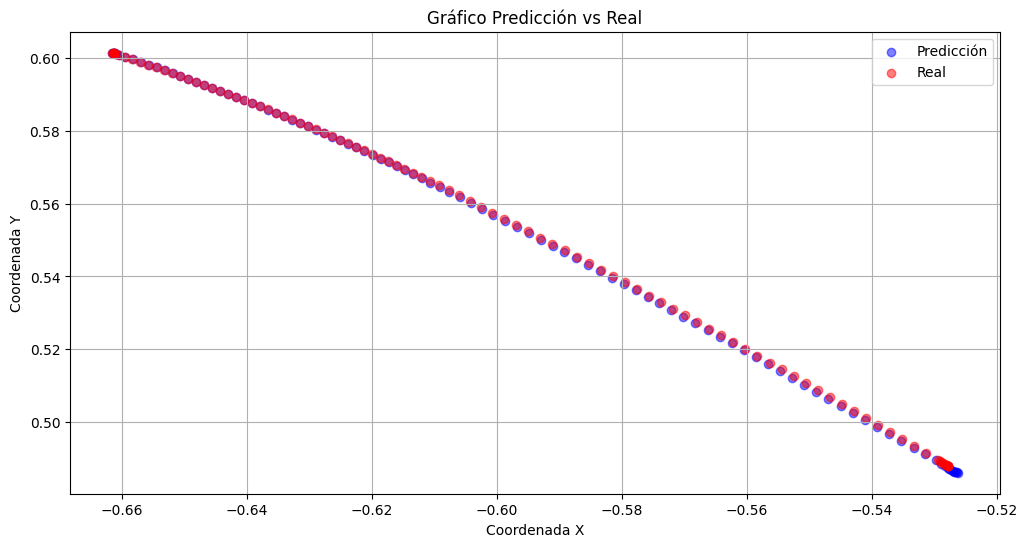

In [93]:
# Graficamos
plt.figure(figsize=(12,6))
plt.scatter(pred_x, pred_y, label='Predicción', color='blue', alpha=0.5)
plt.scatter(true_x, true_y, label='Real', color='red', alpha=0.5)
plt.title("Gráfico Predicción vs Real")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(True)
plt.legend()
plt.show()

In [94]:
model_xy.save('../modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/mod_x_y_R0.keras')

In [95]:
import pickle
with open('../modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_x.pkl', 'wb') as file:
		pickle.dump(scaler_x, file)

with open('../modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_y.pkl', 'wb') as file:
		pickle.dump(scaler_y, file)